# 01 House Price Prediction (Part 1)

In [1]:
import json
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import requests

## i Download Explore Dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Load dataset

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

Explore dataset

Transform to DF

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

## ii Manhattan Data 

####  loop through the data and fill the dataframe one row at a time.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [7]:
manhattan_data=neighborhoods[neighborhoods["Borough"]=="Manhattan"].reset_index(drop=True)

In [8]:
manhattan_data['Neighborhood'].values

array(['Marble Hill', 'Chinatown', 'Washington Heights', 'Inwood',
       'Hamilton Heights', 'Manhattanville', 'Central Harlem',
       'East Harlem', 'Upper East Side', 'Yorkville', 'Lenox Hill',
       'Roosevelt Island', 'Upper West Side', 'Lincoln Square', 'Clinton',
       'Midtown', 'Murray Hill', 'Chelsea', 'Greenwich Village',
       'East Village', 'Lower East Side', 'Tribeca', 'Little Italy',
       'Soho', 'West Village', 'Manhattan Valley', 'Morningside Heights',
       'Gramercy', 'Battery Park City', 'Financial District',
       'Carnegie Hill', 'Noho', 'Civic Center', 'Midtown South',
       'Sutton Place', 'Turtle Bay', 'Tudor City', 'Stuyvesant Town',
       'Flatiron', 'Hudson Yards'], dtype=object)

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [9]:
address = 'Manhattan,New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan,New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan,New York City are 40.7896239, -73.9598939.


Create a map of Manhattan with neighborhoods superimposed on top.

In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], 
                                           manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## iii Explore Foursquare

In [69]:
CLIENT_ID = 'xxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxxxxxxx
CLIENT_SECRET:xxxxxxxx


Let's explore the first neighborhood in our dataframe.

In [13]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

In [14]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

In [15]:
neighborhood_latitude = manhattan_data.loc[0,'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0,'Longitude'] # neighborhood longitude value
radius = 500
LIMIT = 100
categoryId= '4bf58dd8d48988d175941735'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
   categoryId)
results = requests.get(url).json()["response"]['groups'][0]['items']
print(len(results))

7


## iii Explore Neighborhoods in Manhattan

Let's create a function to repeat the same process to all the neighborhoods in Manhattan and find the Gyms in those neighborhoods

In [16]:
#Category id foursquare given to gyms
categoryId='4bf58dd8d48988d175941735'
def getNearbyGyms(names, latitudes, longitudes, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(namname, lat, lnge)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
#         print(len(results))
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the gyms

In [17]:
manhattan_gyms = getNearbyGyms(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                    radius=500
                                  )
manhattan_gyms.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym
1,Marble Hill,40.876551,-73.91066,Blink Fitness,40.877271,-73.905595,Gym / Fitness Center
2,Marble Hill,40.876551,-73.91066,TCR The Club of Riverdale,40.878628,-73.914568,Gym / Fitness Center
3,Marble Hill,40.876551,-73.91066,Planet Fitness,40.874088,-73.909137,Gym / Fitness Center
4,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio


Let's check the size of the resulting dataframe

In [18]:
print(manhattan_gyms.shape)
manhattan_gyms.head()

(1698, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym
1,Marble Hill,40.876551,-73.91066,Blink Fitness,40.877271,-73.905595,Gym / Fitness Center
2,Marble Hill,40.876551,-73.91066,TCR The Club of Riverdale,40.878628,-73.914568,Gym / Fitness Center
3,Marble Hill,40.876551,-73.91066,Planet Fitness,40.874088,-73.909137,Gym / Fitness Center
4,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio


Let's check how many Gyms were returned for each neighborhood

In [19]:
manhattan_gyms.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,32,32,32,32,32,32
Carnegie Hill,52,52,52,52,52,52
Central Harlem,14,14,14,14,14,14
Chelsea,46,46,46,46,46,46
Chinatown,20,20,20,20,20,20
Civic Center,98,98,98,98,98,98
Clinton,50,50,50,50,50,50
East Harlem,10,10,10,10,10,10
East Village,32,32,32,32,32,32


Let's find out how many unique categories can be curated from all the returned venues

In [20]:
print('There are {} uniques categories.'.format(len(manhattan_gyms['Venue Category'].unique())))

There are 40 uniques categories.


## IV Analyze Each Neighborhood

In [21]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_gyms[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']] = manhattan_gyms[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood Longitude,Athletics & Sports,Bike Shop,Boxing Gym,Building,Chiropractor,Climbing Gym,Clothing Store,Club House,College Gym,...,Spa,Spiritual Center,Sporting Event,Tennis Court,Track,Weight Loss Center,Women's Store,Yoga Studio,Neighborhood,Neighborhood Latitude
0,-73.91066,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Marble Hill,40.876551
1,-73.91066,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Marble Hill,40.876551
2,-73.91066,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Marble Hill,40.876551
3,-73.91066,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Marble Hill,40.876551
4,-73.91066,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Marble Hill,40.876551


And let's examine the new dataframe size.

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Neighborhood Longitude,Athletics & Sports,Bike Shop,Boxing Gym,Building,Chiropractor,Climbing Gym,Clothing Store,Club House,...,Residential Building (Apartment / Condo),Spa,Spiritual Center,Sporting Event,Tennis Court,Track,Weight Loss Center,Women's Store,Yoga Studio,Neighborhood Latitude
0,Battery Park City,-74.016869,0.0,0.03125,0.0625,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,40.711932
1,Carnegie Hill,-73.953256,0.0,0.00000,0.0000,0.019231,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.076923,40.782683
2,Central Harlem,-73.943211,0.0,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,40.815976
3,Chelsea,-74.003116,0.0,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.130435,40.744035
4,Chinatown,-73.994279,0.0,0.00000,0.0500,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.150000,40.715618


Getting all the columns

In [23]:
manhattan_grouped.columns

Index(['Neighborhood', 'Neighborhood Longitude', 'Athletics & Sports',
       'Bike Shop', 'Boxing Gym', 'Building', 'Chiropractor', 'Climbing Gym',
       'Clothing Store', 'Club House', 'College Gym', 'Community Center',
       'Cycle Studio', 'Dance Studio', 'Deli / Bodega', 'Doctor's Office',
       'General College & University', 'Gym', 'Gym / Fitness Center',
       'Gym Pool', 'Gymnastics Gym', 'Health & Beauty Service', 'Hospital',
       'Hotel', 'Martial Arts Dojo', 'Massage Studio', 'Medical Center',
       'Nutritionist', 'Office', 'Outdoor Gym', 'Park', 'Pilates Studio',
       'Pool', 'Residential Building (Apartment / Condo)', 'Spa',
       'Spiritual Center', 'Sporting Event', 'Tennis Court', 'Track',
       'Weight Loss Center', 'Women's Store', 'Yoga Studio',
       'Neighborhood Latitude'],
      dtype='object')

Keep only relavent columns

In [24]:
manhattan_grouped=manhattan_grouped[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Climbing Gym','College Gym', 'Community Center', 'Gym', 'Gym / Fitness Center','Gym Pool','Outdoor Gym','Track']]
manhattan_grouped

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Climbing Gym,College Gym,Community Center,Gym,Gym / Fitness Center,Gym Pool,Outdoor Gym,Track
0,Battery Park City,40.711932,-74.016869,0.000000,0.0,0.000000,0.562500,0.281250,0.031250,0.00000,0.000000
1,Carnegie Hill,40.782683,-73.953256,0.000000,0.0,0.019231,0.326923,0.365385,0.019231,0.00000,0.000000
2,Central Harlem,40.815976,-73.943211,0.000000,0.0,0.000000,0.428571,0.357143,0.000000,0.00000,0.000000
3,Chelsea,40.744035,-74.003116,0.000000,0.0,0.000000,0.108696,0.586957,0.021739,0.00000,0.000000
4,Chinatown,40.715618,-73.994279,0.000000,0.0,0.000000,0.350000,0.350000,0.000000,0.00000,0.000000
5,Civic Center,40.715229,-74.005415,0.020408,0.0,0.000000,0.193878,0.448980,0.010204,0.00000,0.000000
6,Clinton,40.759101,-73.996119,0.000000,0.0,0.000000,0.440000,0.460000,0.000000,0.00000,0.020000
7,East Harlem,40.792249,-73.944182,0.000000,0.0,0.000000,0.100000,0.400000,0.000000,0.00000,0.000000
8,East Village,40.727847,-73.982226,0.000000,0.0,0.000000,0.187500,0.312500,0.000000,0.03125,0.000000
9,Financial District,40.707107,-74.010665,0.000000,0.0,0.000000,0.510000,0.420000,0.010000,0.00000,0.000000


Add a score based on the interest to the GYM category. 
Gym Pool = 3
Track = 2
Others = 1 

Then we can calculate the weighted score based on the gym category. 

In [25]:
manhattan_grouped['Score']=manhattan_grouped.apply(lambda x: (x['Gym Pool']*3+ 
                                                              x['Track']*2 +
                                                              x['Climbing Gym']+
                                                              x['College Gym']+ 
                                                              x['Community Center']+ 
                                                              x['Gym']+ x['Gym / Fitness Center']+ 
                                                              x['Outdoor Gym'])/11,axis=1)


Let's print each neighborhood along with the top 5 most common venues

In [26]:
num_top_venues=5
top_mh=manhattan_grouped[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Score','Gym Pool']].sort_values('Score',ascending=False).head(num_top_venues)
top_mh

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Score,Gym Pool
32,Tribeca,40.721522,-74.010683,0.090909,0.066667
28,Roosevelt Island,40.762160,-73.949168,0.090909,0.000000
25,Morningside Heights,40.808000,-73.963896,0.090909,0.200000
21,Manhattanville,40.816934,-73.957385,0.090909,0.000000
33,Tudor City,40.746917,-73.971219,0.088692,0.048780


In [27]:
topGym_map = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, neighborhood in zip(top_mh['Neighborhood Latitude'], top_mh['Neighborhood Longitude'], 
                                           top_mh['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(topGym_map)  
    
topGym_map

Now we can see that the Neighborhood "Tribeca" has got the highest weighted score + gym pool score. Our "Gym Goer" is now definitly going to select the Tribeca to his house. Let's help him to predict the avarage price he has to score for buying a house from "Tribeca" in the part 2

# 02 House Price Prediction (Part 2)

In [28]:
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import math 

## i. Data Understanding and Preprocessing

### Explore Data

In [29]:
df=pd.read_excel('input2.xls')
df.head()

,NEIGHBORHOOD,TYPE OF HOME,NUMBER OF SALES,LOWEST SALE PRICE,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,YEAR
0,ALPHABET CITY,02 TWO FAMILY HOMES,1,2675000,2675000.0,2675000.0,2675000,2005
1,ALPHABET CITY,03 THREE FAMILY HOMES,1,4200000,4200000.0,4200000.0,4200000,2005
2,CHELSEA,01 ONE FAMILY HOMES,2,217500,1958750.0,1958750.0,3700000,2005
3,CHELSEA,02 TWO FAMILY HOMES,3,3200000,3750000.0,3800000.0,4250000,2005
4,CHELSEA,03 THREE FAMILY HOMES,2,2800000,2900000.0,2900000.0,3000000,2005


#### Drop LOWEST SALE PRICE, MEDIAN SALE PRICE, HIGHEST SALE PRICE

In [30]:
df.drop(['LOWEST SALE PRICE', 'MEDIAN SALE PRICE', 'HIGHEST SALE PRICE'],inplace=True, axis = 1) 
df.head()

,NEIGHBORHOOD,TYPE OF HOME,NUMBER OF SALES,AVERAGE SALE PRICE,YEAR
0,ALPHABET CITY,02 TWO FAMILY HOMES,1,2675000.0,2005
1,ALPHABET CITY,03 THREE FAMILY HOMES,1,4200000.0,2005
2,CHELSEA,01 ONE FAMILY HOMES,2,1958750.0,2005
3,CHELSEA,02 TWO FAMILY HOMES,3,3750000.0,2005
4,CHELSEA,03 THREE FAMILY HOMES,2,2900000.0,2005


#### Remove Null values

In [31]:
df.dropna(inplace=True)

### Analys the AVARAGE SALE PRICE

In [32]:
df['AVERAGE SALE PRICE'].describe()

count    7.910000e+02
mean     5.111178e+06
std      4.097849e+06
min      2.000000e+05
25%      1.782600e+06
50%      4.250000e+06
75%      7.157252e+06
max      2.689300e+07
Name: AVERAGE SALE PRICE, dtype: float64

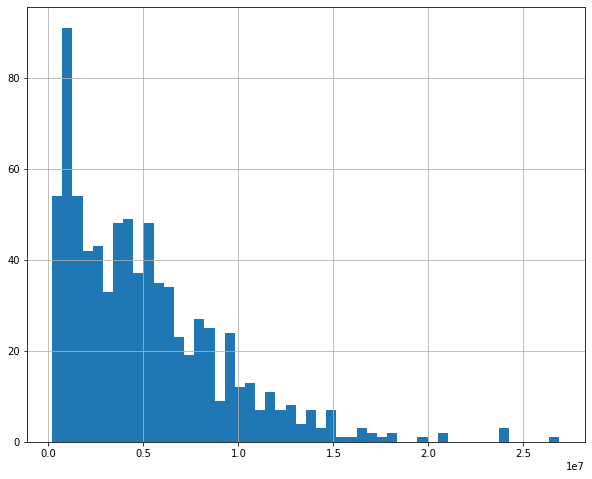

In [33]:
df['AVERAGE SALE PRICE'].hist(bins = 50,figsize=(10,8))

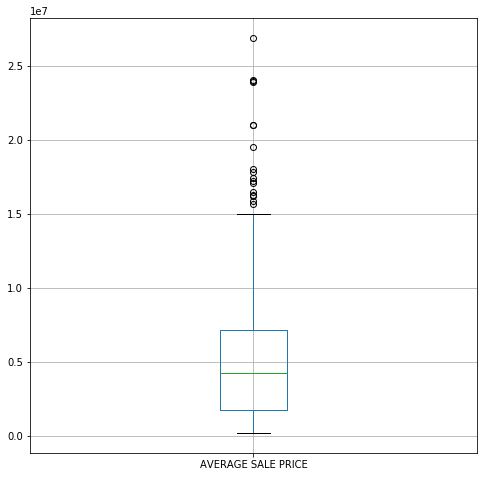

In [34]:
df.boxplot(column='AVERAGE SALE PRICE',figsize=(8,8))

In [35]:
# Remove Outliers
Q1 = df['AVERAGE SALE PRICE'].quantile(0.25)
Q3 = df['AVERAGE SALE PRICE'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

outliers=df[(df['AVERAGE SALE PRICE'] < (Q1 - 1.5 * IQR)) | (df['AVERAGE SALE PRICE'] > (Q3 + 1.5 *IQR))]
print("Removed ",len(outliers)," outliers")
      
df= df[(df['AVERAGE SALE PRICE'] >= Q1 - 1.5 * IQR) & (df['AVERAGE SALE PRICE'] <= Q3 + 1.5 *IQR)]

Removed  17  outliers


### Applying One Hot Encoding for NEIGHBORHOOD

In [36]:
neig_len=len(df.NEIGHBORHOOD.unique())
df.NEIGHBORHOOD.unique()

array(['ALPHABET CITY            ', 'CHELSEA                  ',
       'CLINTON                  ', 'EAST VILLAGE             ',
       'GRAMERCY                 ', 'GREENWICH VILLAGE-CENTRAL',
       'GREENWICH VILLAGE-WEST   ', 'HARLEM-CENTRAL           ',
       'HARLEM-EAST              ', 'HARLEM-UPPER             ',
       'INWOOD                   ', 'KIPS BAY                 ',
       'LITTLE ITALY             ', 'MANHATTAN VALLEY         ',
       'MIDTOWN EAST             ', 'MURRAY HILL              ',
       'SOHO                     ', 'TRIBECA                  ',
       'UPPER EAST SIDE (59-79)  ', 'UPPER EAST SIDE (79-96)  ',
       'UPPER WEST SIDE (59-79)  ', 'UPPER WEST SIDE (79-96)  ',
       'UPPER WEST SIDE (96-116) ', 'WASHINGTON HEIGHTS LOWER ',
       'WASHINGTON HEIGHTS UPPER ', 'CIVIC CENTER             ',
       'LOWER EAST SIDE          ', 'MIDTOWN WEST             ',
       'CHINATOWN                ', 'FASHION                  ',
       'HARLEM-WEST      

We can see that there is a white spaced NEIGHBORHOOD value in here. Let's remove it.

In [37]:
df.NEIGHBORHOOD=df.NEIGHBORHOOD.str.strip()
print(" Old Length ",neig_len," New Length ",len(df.NEIGHBORHOOD.unique()))

 Old Length  55  New Length  34


In [38]:
df.NEIGHBORHOOD.unique()

array(['ALPHABET CITY', 'CHELSEA', 'CLINTON', 'EAST VILLAGE', 'GRAMERCY',
       'GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE-WEST',
       'HARLEM-CENTRAL', 'HARLEM-EAST', 'HARLEM-UPPER', 'INWOOD',
       'KIPS BAY', 'LITTLE ITALY', 'MANHATTAN VALLEY', 'MIDTOWN EAST',
       'MURRAY HILL', 'SOHO', 'TRIBECA', 'UPPER EAST SIDE (59-79)',
       'UPPER EAST SIDE (79-96)', 'UPPER WEST SIDE (59-79)',
       'UPPER WEST SIDE (79-96)', 'UPPER WEST SIDE (96-116)',
       'WASHINGTON HEIGHTS LOWER', 'WASHINGTON HEIGHTS UPPER',
       'CIVIC CENTER', 'LOWER EAST SIDE', 'MIDTOWN WEST', 'CHINATOWN',
       'FASHION', 'HARLEM-WEST', 'SOUTHBRIDGE', 'FLATIRON',
       'JAVITS CENTER'], dtype=object)

In [39]:
#replacing ' ' with NaN
# df.NEIGHBORHOOD.replace(r'^\s*$', np.nan, regex=True,inplace=True)
# df.NEIGHBORHOOD.unique()

In [40]:
df.dropna(inplace=True)

In [41]:
one_hot_features = ['NEIGHBORHOOD']
one_hot_encoded = pd.get_dummies(df[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

# Replacing categorical columns with dummies
df = df.drop(one_hot_features,axis=1)
df = pd.concat([df, one_hot_encoded] ,axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774 entries, 0 to 790
Data columns (total 34 columns):
NEIGHBORHOOD_ALPHABET CITY                774 non-null uint8
NEIGHBORHOOD_CHELSEA                      774 non-null uint8
NEIGHBORHOOD_CHINATOWN                    774 non-null uint8
NEIGHBORHOOD_CIVIC CENTER                 774 non-null uint8
NEIGHBORHOOD_CLINTON                      774 non-null uint8
NEIGHBORHOOD_EAST VILLAGE                 774 non-null uint8
NEIGHBORHOOD_FASHION                      774 non-null uint8
NEIGHBORHOOD_FLATIRON                     774 non-null uint8
NEIGHBORHOOD_GRAMERCY                     774 non-null uint8
NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL    774 non-null uint8
NEIGHBORHOOD_GREENWICH VILLAGE-WEST       774 non-null uint8
NEIGHBORHOOD_HARLEM-CENTRAL               774 non-null uint8
NEIGHBORHOOD_HARLEM-EAST                  774 non-null uint8
NEIGHBORHOOD_HARLEM-UPPER                 774 non-null uint8
NEIGHBORHOOD_HARLEM-WEST                 

### Lablel Encoding For Type of Home Data

#### Removing unwanted ending white space

In [42]:
df['TYPE OF HOME'].unique()

array(['02 TWO FAMILY HOMES                        ',
       '03 THREE FAMILY HOMES                      ',
       '01 ONE FAMILY HOMES                        ',
       '01 ONE FAMILY HOMES     ', '02 TWO FAMILY HOMES     ',
       '03 THREE FAMILY HOMES   ', '01  ONE FAMILY HOMES  ',
       '03  THREE FAMILY HOMES', '02  TWO FAMILY HOMES  ',
       '01 ONE FAMILY DWELLINGS', '03 THREE FAMILY DWELLINGS',
       '02 TWO FAMILY DWELLINGS'], dtype=object)

In [43]:
df['TYPE OF HOME']=df.apply(lambda x: int(x['TYPE OF HOME'].strip().split(" ")[0]),axis=1 )
df['TYPE OF HOME'].unique()

array([2, 3, 1])

In [44]:
df.head()

,TYPE OF HOME,NUMBER OF SALES,AVERAGE SALE PRICE,YEAR,NEIGHBORHOOD_ALPHABET CITY,NEIGHBORHOOD_CHELSEA,NEIGHBORHOOD_CHINATOWN,NEIGHBORHOOD_CIVIC CENTER,NEIGHBORHOOD_CLINTON,NEIGHBORHOOD_EAST VILLAGE,...,NEIGHBORHOOD_SOHO,NEIGHBORHOOD_SOUTHBRIDGE,NEIGHBORHOOD_TRIBECA,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (96-116),NEIGHBORHOOD_WASHINGTON HEIGHTS LOWER,NEIGHBORHOOD_WASHINGTON HEIGHTS UPPER
0,2,1,2675000.0,2005,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,1,4200000.0,2005,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,1958750.0,2005,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,3,3750000.0,2005,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2,2900000.0,2005,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Scaling Type OF NUMBER OF SALES, HOME and YEAR FEILDS

In [45]:

inputScaler = MinMaxScaler(feature_range=(0, 1))
inputScaler.fit(df[['YEAR','TYPE OF HOME','NUMBER OF SALES']])
df[['YEAR','TYPE OF HOME','NUMBER OF SALES']]=inputScaler.transform(
                                                      df[['YEAR','TYPE OF HOME','NUMBER OF SALES']]
                                              )

In [46]:
#lets standarscale the AVERAGE SALE PRICE feild

targetScaler = StandardScaler()
df["AVERAGE SALE PRICE"] = pd.to_numeric(df["AVERAGE SALE PRICE"])

targetScaler.fit(df[['AVERAGE SALE PRICE']])
df[['AVERAGE SALE PRICE']]=targetScaler.transform(df[['AVERAGE SALE PRICE']])

#Rename AVARAGE SALE PRICE to PRICE
df.rename(columns={'AVERAGE SALE PRICE': 'PRICE'},inplace=True)


In [47]:
# df.rename(columns={'AVERAGE SALE PRICE': 'PRICE'},inplace=True)
# df.columns

## ii. Train/Test Split

### Set 1

In [48]:
y_df = df['PRICE']
X_df = df.drop('PRICE', axis=1)
X_train ,X_test, y_train , y_test = train_test_split(X_df , y_df , test_size = 0.3 , random_state =34)

### Set 2 (Keeping 2018 data for validation)

In [49]:
#with Validation 
V_df=df[df['YEAR']==1] #2018 data
V_X=V_df.drop('PRICE', axis=1)
V_Y=V_df.drop('PRICE', axis=1)

#Train and test
T_df=df[df['YEAR']<1]
y_df1 = T_df['PRICE']
X_df1 = T_df.drop('PRICE', axis=1)
X_train1 ,X_test1, y_train1 , y_test1 = train_test_split(X_df1 , y_df1 , test_size = 0.3 , random_state =34)


## iii. Modeling

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor


# RMSE
import numpy as np
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))
    
#loss
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Using TensorFlow backend.


### Linear Models

In [51]:
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    print('Defined %d models' % len(models))
    return models

In [52]:
def evaluate_models(models, train, test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_lr = model.predict(X_test)
        print(name ,' ',rmse(y_test,y_pred_lr))

        
evaluate_models(get_models(), X_train, y_train)

Defined 8 models
lr   98038212533.73795
lasso   1.0075337136387226
ridge   0.5800752366313123
en   1.0075337136387226
huber   0.5825974677474416
llars   1.0075337136387226
pa   1.15786184781912
sgd   0.6105715094570967


### Non linear Model 

In [53]:
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
 
# prepare a list of ml models
def get_nl_models(models=dict()):
    # non-linear models
    models['knn'] = KNeighborsRegressor(n_neighbors=7)
    models['cart'] = DecisionTreeRegressor()
    models['extra'] = ExtraTreeRegressor()
    models['svmr'] = SVR()
    # # ensemble models
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    print('Defined %d models' % len(models))
    return models

def evaluate_models(models, train, test):
    for name, model in models.items():
        lr_model=model
        lr_model.fit(X_train, y_train)
        y_pred_lr = lr_model.predict(X_test)
        print(name ,' ',rmse(y_test,y_pred_lr))
        
evaluate_models(get_nl_models(), X_train, y_train)

Defined 9 models
knn   0.6115348979963127
cart   0.7990790438320381
extra   0.8176895022656956
svmr   0.65808984655588
ada   0.9033841394108615


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


bag   0.6439516032982129
rf   0.6350175661160599
et   0.6713772780175207
gbm   0.6003605990187098


### Neural Network

In [54]:
from keras.models import Sequential
from keras.layers import Activation, Dense

# define base model
def baseline_model(dim=37):
    # create model
    model = Sequential()
    model.add(Dense(5, name="input", input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1,name="output",  kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    return model

epochs, batch_size = 100, 5
nn = baseline_model()
nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
y_pred_nn = nn.predict(X_test)
rmse(y_pred_nn,y_test)


0.5687398985377833

## iV. Visualization

#### Reinitializatio and Train the model (without 2018 data)

In [55]:
nn = baseline_model()
nn.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size, verbose=0)
# model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
y_pred_nn = nn.predict(X_test1)
rmse(y_pred_nn,y_test1)

0.5834376174205999

In [56]:
#Prepare the x label values
def getXLables(h_type,neighborhood):
    out=[]
    for i in range(0,len(h_type)):
        out.append("Type_"+str(h_type[i])+"_"+str(X[i]))
    return(out)

In [57]:
#Preparing data
X= V_df.drop(['PRICE','YEAR','NUMBER OF SALES','TYPE OF HOME'], axis=1).idxmax(axis=1).values
h_type= V_df['TYPE OF HOME'].values
xlables=getXLables(h_type,X)

y=V_df['PRICE']
X_t=V_df.drop('PRICE', axis=1)
y_=nn.predict(X_t)


#### Data Visualization

W0411 22:02:23.284455 140282693879616 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0411 22:02:23.285752 140282693879616 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0411 22:02:23.811080 140282693879616 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0411 22:02:23.812374 140282693879616 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


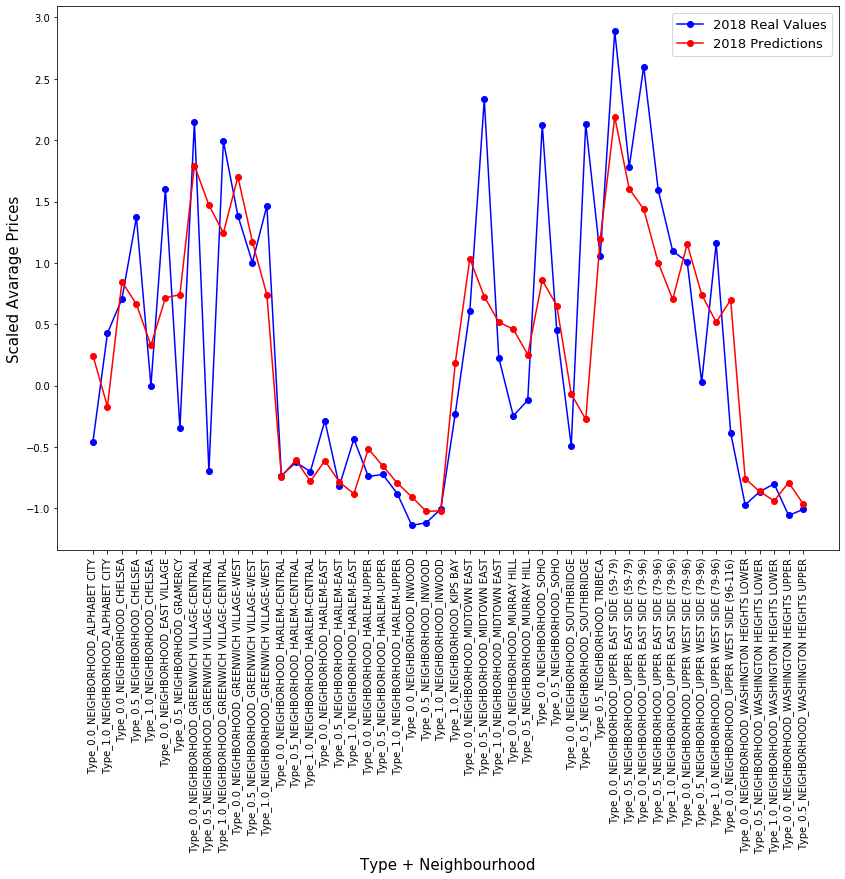

In [58]:
plt.figure(figsize=(14,10))
plt.plot(xlables,y.values, marker='o',color='b')
plt.plot(xlables,y_, marker='o',color='r')
plt.legend(['2018 Real Values','2018 Predictions'],prop={'size': 13}, loc='upper right')
plt.ylabel('Scaled Avarage Prices',fontsize=15)
plt.xlabel('Type + Neighbourhood',fontsize=15)
plt.xticks(rotation=90)
plt.savefig('figure6.eps', bbox_inches = 'tight',format='eps')
plt.show()

### Prediction

We previously modeled the data with YEAR, TYPE OF HOME and NUMBER OF SALES. But when we are predicting the avarage price for a new year we only have YEAR and TYPE OF HOME that we are looking for. We don't have the NUMBER OF SALES. So lets train the model with YEAR AND TYPE OF HOME features. We will be using the model with the best accuracy. 

In [59]:
df.columns

Index(['TYPE OF HOME', 'NUMBER OF SALES', 'PRICE', 'YEAR',
       'NEIGHBORHOOD_ALPHABET CITY', 'NEIGHBORHOOD_CHELSEA',
       'NEIGHBORHOOD_CHINATOWN', 'NEIGHBORHOOD_CIVIC CENTER',
       'NEIGHBORHOOD_CLINTON', 'NEIGHBORHOOD_EAST VILLAGE',
       'NEIGHBORHOOD_FASHION', 'NEIGHBORHOOD_FLATIRON',
       'NEIGHBORHOOD_GRAMERCY', 'NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL',
       'NEIGHBORHOOD_GREENWICH VILLAGE-WEST', 'NEIGHBORHOOD_HARLEM-CENTRAL',
       'NEIGHBORHOOD_HARLEM-EAST', 'NEIGHBORHOOD_HARLEM-UPPER',
       'NEIGHBORHOOD_HARLEM-WEST', 'NEIGHBORHOOD_INWOOD',
       'NEIGHBORHOOD_JAVITS CENTER', 'NEIGHBORHOOD_KIPS BAY',
       'NEIGHBORHOOD_LITTLE ITALY', 'NEIGHBORHOOD_LOWER EAST SIDE',
       'NEIGHBORHOOD_MANHATTAN VALLEY', 'NEIGHBORHOOD_MIDTOWN EAST',
       'NEIGHBORHOOD_MIDTOWN WEST', 'NEIGHBORHOOD_MURRAY HILL',
       'NEIGHBORHOOD_SOHO', 'NEIGHBORHOOD_SOUTHBRIDGE', 'NEIGHBORHOOD_TRIBECA',
       'NEIGHBORHOOD_UPPER EAST SIDE (59-79)',
       'NEIGHBORHOOD_UPPER EAST SIDE (7

In [60]:
y_df2 = df['PRICE']
X_df2 = df.drop(['PRICE','NUMBER OF SALES'], axis=1)
X_train2 ,X_test2, y_train2 , y_test2 = train_test_split(X_df2 ,
                                                         y_df2 , test_size = 0.3 ,
                                                         random_state =35)

In [61]:
nn2 = baseline_model(dim=36) #one feature has be removed
nn2.fit(X_train2, y_train2, epochs=epochs, batch_size=batch_size, verbose=0)

y_pred_nn2 = nn2.predict(X_test2)
rmse(y_pred_nn2,y_test2)

0.6034725829477506

#### Encode input neighbourhood

In [62]:
nhoods=['NEIGHBORHOOD_ALPHABET CITY', 'NEIGHBORHOOD_CHELSEA', 
        'NEIGHBORHOOD_CHINATOWN', 'NEIGHBORHOOD_CIVIC CENTER', 'NEIGHBORHOOD_CLINTON',
        'NEIGHBORHOOD_EAST VILLAGE', 'NEIGHBORHOOD_FASHION', 'NEIGHBORHOOD_FLATIRON', 
        'NEIGHBORHOOD_GRAMERCY', 'NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL', 
        'NEIGHBORHOOD_GREENWICH VILLAGE-WEST', 'NEIGHBORHOOD_HARLEM-CENTRAL', 
        'NEIGHBORHOOD_HARLEM-EAST', 'NEIGHBORHOOD_HARLEM-UPPER', 'NEIGHBORHOOD_HARLEM-WEST', 
        'NEIGHBORHOOD_INWOOD', 'NEIGHBORHOOD_JAVITS CENTER', 'NEIGHBORHOOD_KIPS BAY', 
        'NEIGHBORHOOD_LITTLE ITALY', 'NEIGHBORHOOD_LOWER EAST SIDE', 'NEIGHBORHOOD_MANHATTAN VALLEY',
        'NEIGHBORHOOD_MIDTOWN EAST', 'NEIGHBORHOOD_MIDTOWN WEST', 'NEIGHBORHOOD_MURRAY HILL',
        'NEIGHBORHOOD_SOHO', 'NEIGHBORHOOD_SOUTHBRIDGE', 'NEIGHBORHOOD_TRIBECA', 
        'NEIGHBORHOOD_UPPER EAST SIDE (59-79)', 'NEIGHBORHOOD_UPPER EAST SIDE (79-96)',
        'NEIGHBORHOOD_UPPER WEST SIDE (59-79)', 'NEIGHBORHOOD_UPPER WEST SIDE (79-96)', 
        'NEIGHBORHOOD_UPPER WEST SIDE (96-116)', 'NEIGHBORHOOD_WASHINGTON HEIGHTS LOWER', 
        'NEIGHBORHOOD_WASHINGTON HEIGHTS UPPER']
nhoods_input=listofzeros = [0] * len(nhoods)
nhoods_input[nhoods.index('NEIGHBORHOOD_TRIBECA')]=1

In [63]:
input = [2020,1,0] # 2020 for year 2020 and 1 for single home,
# dummy number of sales feature is added ans will be removed later
YT_input=inputScaler.transform([input])
input=YT_input[0][:-1]
input=list(input) + nhoods_input
input=np.asarray(input, dtype=np.float32).reshape(1,36)

In [64]:
input

array([[1.0714285, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 1.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ]],
      dtype=float32)

In [65]:
#checking input dimentions with the training X data
assert(len(X_df2.iloc[0])==len(input[0]))
price= nn2.predict(input)
avg_price=targetScaler.inverse_transform([price])
print("predicted TRIBECA avarage house price for 1 Member Family is",avg_price[0][0])

predicted TRIBECA avarage house price for 1 Member Family is [4636015.5]


#### The avarage price variation of one member family in TRIBECA

In [66]:
temp=df[(df['TYPE OF HOME']==0) & (df['NEIGHBORHOOD_TRIBECA']==1)]
X=temp['YEAR']
y=temp['PRICE']

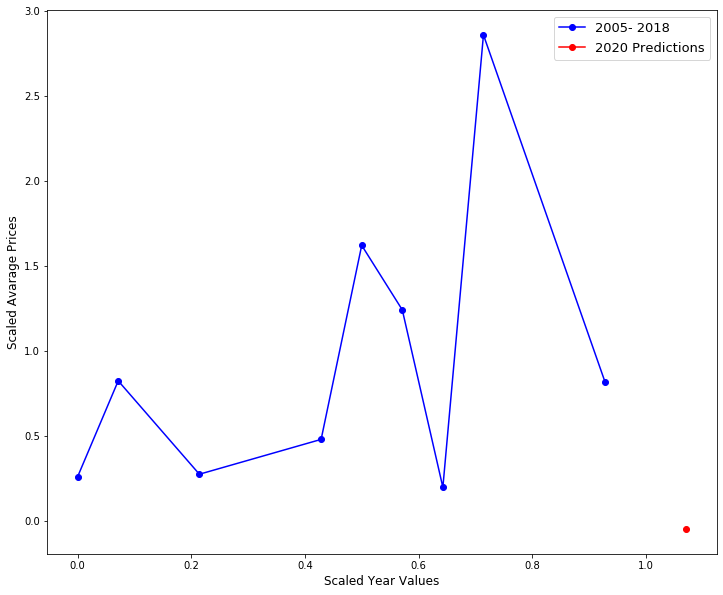

In [67]:
plt.figure(figsize=(12,10))
plt.plot(X,y, marker='o',color='b')
plt.plot(YT_input[0][0],price, marker='o',color='r')
plt.legend(['2005- 2018','2020 Predictions'],prop={'size': 13}, loc='upper right')
plt.ylabel('Scaled Avarage Prices',fontsize=12)
plt.xlabel('Scaled Year Values',fontsize=12)
plt.show()